<div align=center>

# Linear regression workflow 📈

</div>

## Check if the kernel is up and working ✨

In [247]:
print("Kernel works!")

Kernel works!


### Import required packages 📦

In [248]:
from safetensors.torch import save_file
from safetensors.torch import safe_open
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import torch

## Setup PyTorch🔥

In [249]:
# Print PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Set float16 as dtype for more optimized computation
torch.set_default_dtype(torch.half)

# Check if GPU is available
if torch.cuda.is_available():
    print("GPUs are available!")
    print("Amount of available GPUs:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i} name:", torch.cuda.get_device_name(i))
else:
    print("GPU is not available. Will use CPU instead")

PyTorch version: 2.5.0+cu124
GPU is not available. Will use CPU instead


## Setup the workflow ⚒️
<div align=center>

![pytorch_workflow](pytorch_workflow.png)

</div>

### 1. Get data ready 🔢

#### Define a plotting functions

In [250]:
# Define data plotting function
def plot_data(train_data, test_data, train_labels, test_labels, title="Data plot", predictions=None):
    # Set the font to be JetBrains Mono
    font_path = Path("../fonts/JetBrainsMono-Regular.ttf")

    # Set the dark mode
    plt.style.use('dark_background')

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.plot(train_data, train_labels, c="green", label="Training data")
    plt.scatter(train_data, train_labels, c="green")

    plt.plot(test_data, test_labels, c="orange", label="Validation data")
    plt.scatter(test_data, test_labels, c="orange")

    if predictions is not None:
        plt.plot(test_data, predictions, c="red", label="Model predictions")
        plt.scatter(test_data, predictions, c="red")

    # Setting up axes
    plt.title(title, font=font_path, fontsize=16)
    plt.xlabel('X', font=font_path, fontsize=14)
    plt.ylabel('Y', font=font_path, fontsize=14)

    # Add grid and axes lines
    plt.axhline(0, color='white', lw=0.5, ls='--')
    plt.axvline(0, color='white', lw=0.5, ls='--')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Customize ticks
    plt.xticks(font=font_path)
    plt.yticks(font=font_path)

    # Add a legend
    plt.legend(prop=font_path)

In [251]:
# Define loss curves plotting function
def plot_loss_curves(train_loss, val_loss, epoch_count, title="Loss curves plot"):
    # Set the font to be JetBrains Mono
    font_path = Path("../fonts/JetBrainsMono-Regular.ttf")

    # Set the dark mode
    plt.style.use('dark_background')

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.plot(epoch_count, train_loss, c="green", label="Training loss")
    plt.plot(epoch_count, val_loss, c="orange", label="Validation loss")

    # Setting up axes
    plt.title(title, font=font_path, fontsize=16)
    plt.xlabel('X', font=font_path, fontsize=14)
    plt.ylabel('Y', font=font_path, fontsize=14)

    # Add grid and axes lines
    plt.axhline(0, color='white', lw=0.5, ls='--')
    plt.axvline(0, color='white', lw=0.5, ls='--')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Customize ticks
    plt.xticks(font=font_path)
    plt.yticks(font=font_path)

    # Add a legend
    plt.legend(prop=font_path)

#### Generate example data

In [252]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Number of samples
num_samples = 32

# Generate random input features (x) and corresponding labels (y)
X = torch.linspace(0, 1, num_samples).unsqueeze(1)  # Shape (25, 1)
# Let's assume a linear relationship: y = 0.7 * x + 0.3
y = 0.7 * X + 0.3

data_df = pd.DataFrame({'X': X.numpy().flatten(), 'y': y.numpy().flatten()})

# Create train/test split
train_split = int(0.75 * len(X))  # 50% of data used for training set, 50% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_val, y_val = X[train_split:], y[train_split:]

# Convert to pandas DataFrame
train_df = pd.DataFrame({'X': X_train.numpy().flatten(), 'y': y_train.numpy().flatten()})
test_df = pd.DataFrame({'X': X_val.numpy().flatten(), 'y': y_val.numpy().flatten()})

### 2. Build a model ⚒️

#### Build a model class

In [253]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.nn.Parameter(torch.randn(1))
        self.bias = torch.nn.Parameter(torch.randn(1))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

#### Build a training and validation loops

Epoch: 0 (0.78% complete) | Training Loss: 0.3062 | Validation Loss: 0.3049
Epoch: 1 (1.56% complete) | Training Loss: 0.1689 | Validation Loss: 0.1164
Epoch: 2 (2.34% complete) | Training Loss: 0.0398 | Validation Loss: 0.0661
Epoch: 3 (3.12% complete) | Training Loss: 0.0991 | Validation Loss: 0.1337
Epoch: 4 (3.91% complete) | Training Loss: 0.1460 | Validation Loss: 0.1355
Epoch: 5 (4.69% complete) | Training Loss: 0.1451 | Validation Loss: 0.0949
Epoch: 6 (5.47% complete) | Training Loss: 0.1134 | Validation Loss: 0.0245
Epoch: 7 (6.25% complete) | Training Loss: 0.0606 | Validation Loss: 0.0672
Epoch: 8 (7.03% complete) | Training Loss: 0.0229 | Validation Loss: 0.1345
Epoch: 9 (7.81% complete) | Training Loss: 0.0608 | Validation Loss: 0.1599
Epoch: 10 (8.59% complete) | Training Loss: 0.0823 | Validation Loss: 0.1521
Epoch: 11 (9.38% complete) | Training Loss: 0.0790 | Validation Loss: 0.1175
Epoch: 12 (10.16% complete) | Training Loss: 0.0557 | Validation Loss: 0.0610
Epoch: 1

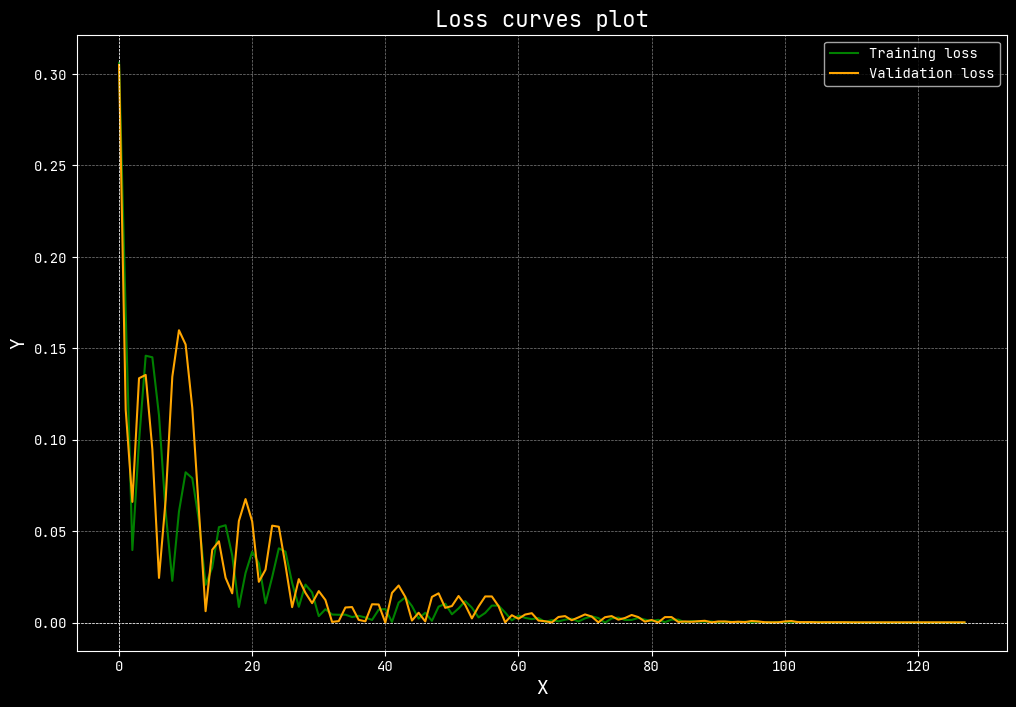

In [254]:
class ConsoleColor:
    RED = '\033[91m'
    ORANGE = '\033[93m'
    GREEN = '\033[92m'
    RESET = '\033[0m'

# Initialize model, loss function, optimizer, and learning rate scheduler
model = LinearRegressionModel()
loss_function = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
learning_rate_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

num_epochs = 2**7
log_interval = max(1, num_epochs // 10000)
loss_thresholds = [0.01, 0.1]  # 95% and 50% thresholds
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    # Training Loop
    model.train() # Set the model to training mode

    # Compute loss on training data
    train_loss = loss_function(model(X_train), y_train)  # Assuming X_train and y_train are defined
    
    optimizer.zero_grad()  # Clear gradients
    train_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    learning_rate_scheduler.step(train_loss.item())  # Adjust learning rate based on train loss

    # Color assignment based on loss
    if train_loss.item() < loss_thresholds[0]:
        loss_color = ConsoleColor.GREEN
    elif train_loss.item() < loss_thresholds[1]:
        loss_color = ConsoleColor.ORANGE
    else:
        loss_color = ConsoleColor.RED

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():  # Disable gradient tracking
        val_loss = loss_function(model(X_val), y_val)  # Assuming X_val and y_val are defined
        train_loss_history.append(train_loss.item())
        val_loss_history.append(val_loss.item())

    if epoch % log_interval == 0:
        print(f"Epoch: {epoch} ({(epoch + 1) / num_epochs * 100:.2f}% complete)"
            f" | Training Loss: {loss_color}{train_loss.item():.4f}{ConsoleColor.RESET}"
            f" | Validation Loss: {loss_color}{val_loss.item():.4f}{ConsoleColor.RESET}")

plot_loss_curves(train_loss_history, val_loss_history, range(num_epochs))

### 3. Save a model 💾

In [255]:
model_path = Path("../models/linreg.safetensors")
model_path.parent.mkdir(parents=True, exist_ok=True)

model_params = {
    'weights': model.weights.data,
    'bias': model.bias.data
}
save_file(model_params, model_path)

### 4. (Re)load a model 🔃

In [256]:
tensors = {}
with safe_open(model_path, framework="pt") as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)

for name, tensor in tensors.items():
    if hasattr(model, name):
        setattr(model, name, torch.nn.Parameter(tensor))

### 5. Plot model prediction performance ✨

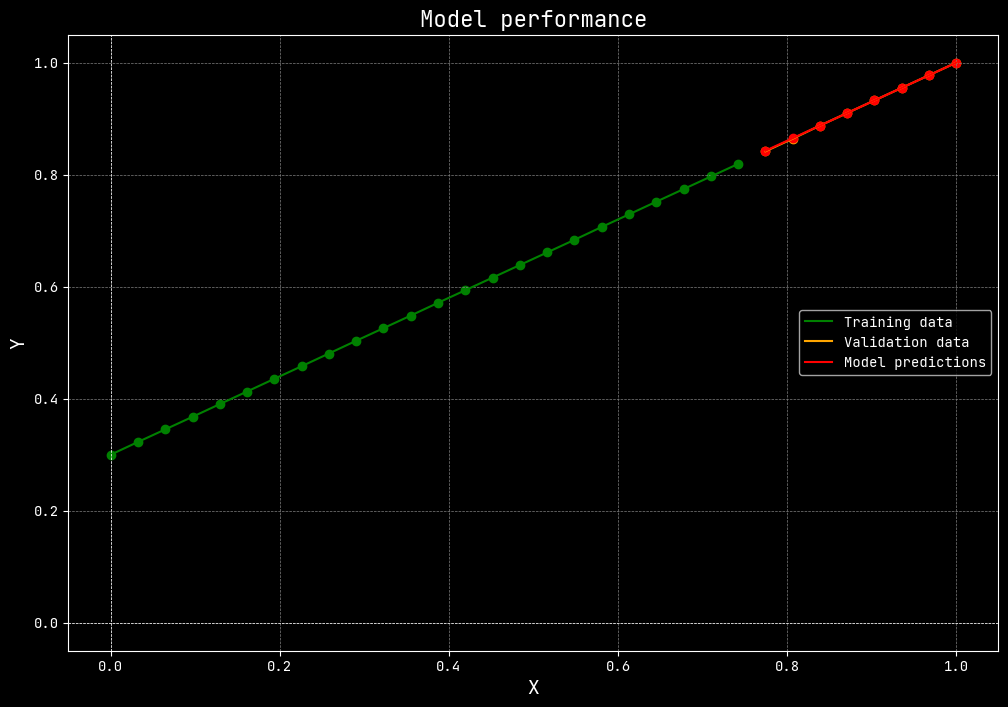

In [257]:
with torch.inference_mode():
    y_preds = model(X_val)
plot_data(X_train, X_val, y_train, y_val, "Model performance", y_preds)